# How to delta hedge an option: Part IV

## Hedging frequency & more pretty scatterplots

We left the previous article having established that miraculously the process of just holding:
 - cash
 - stocks

and adjusting this quantity of stocks frequently according to what the Black-Scholes delta tells us.Sure, there are lots of assumptions embedded in the way we have set up our simulations but we can start breaking them down later and reveal if the previous conclusions head into the bin with them.

First, let's start drilling down into the hedging error we get - why aren't all our paths _exactly_ equal to the theoretical terminal value?

## Hedging error

In order to have a bit of a closer look let's combine the two graphs. In other words let's pretend that we sell the call option and go about doing this replication so that at expiry we use our replicating portfolio cash to pay the call option payoff (if there is one - if ITM). By combining the two we can single out the 'hedging error' that we experience.

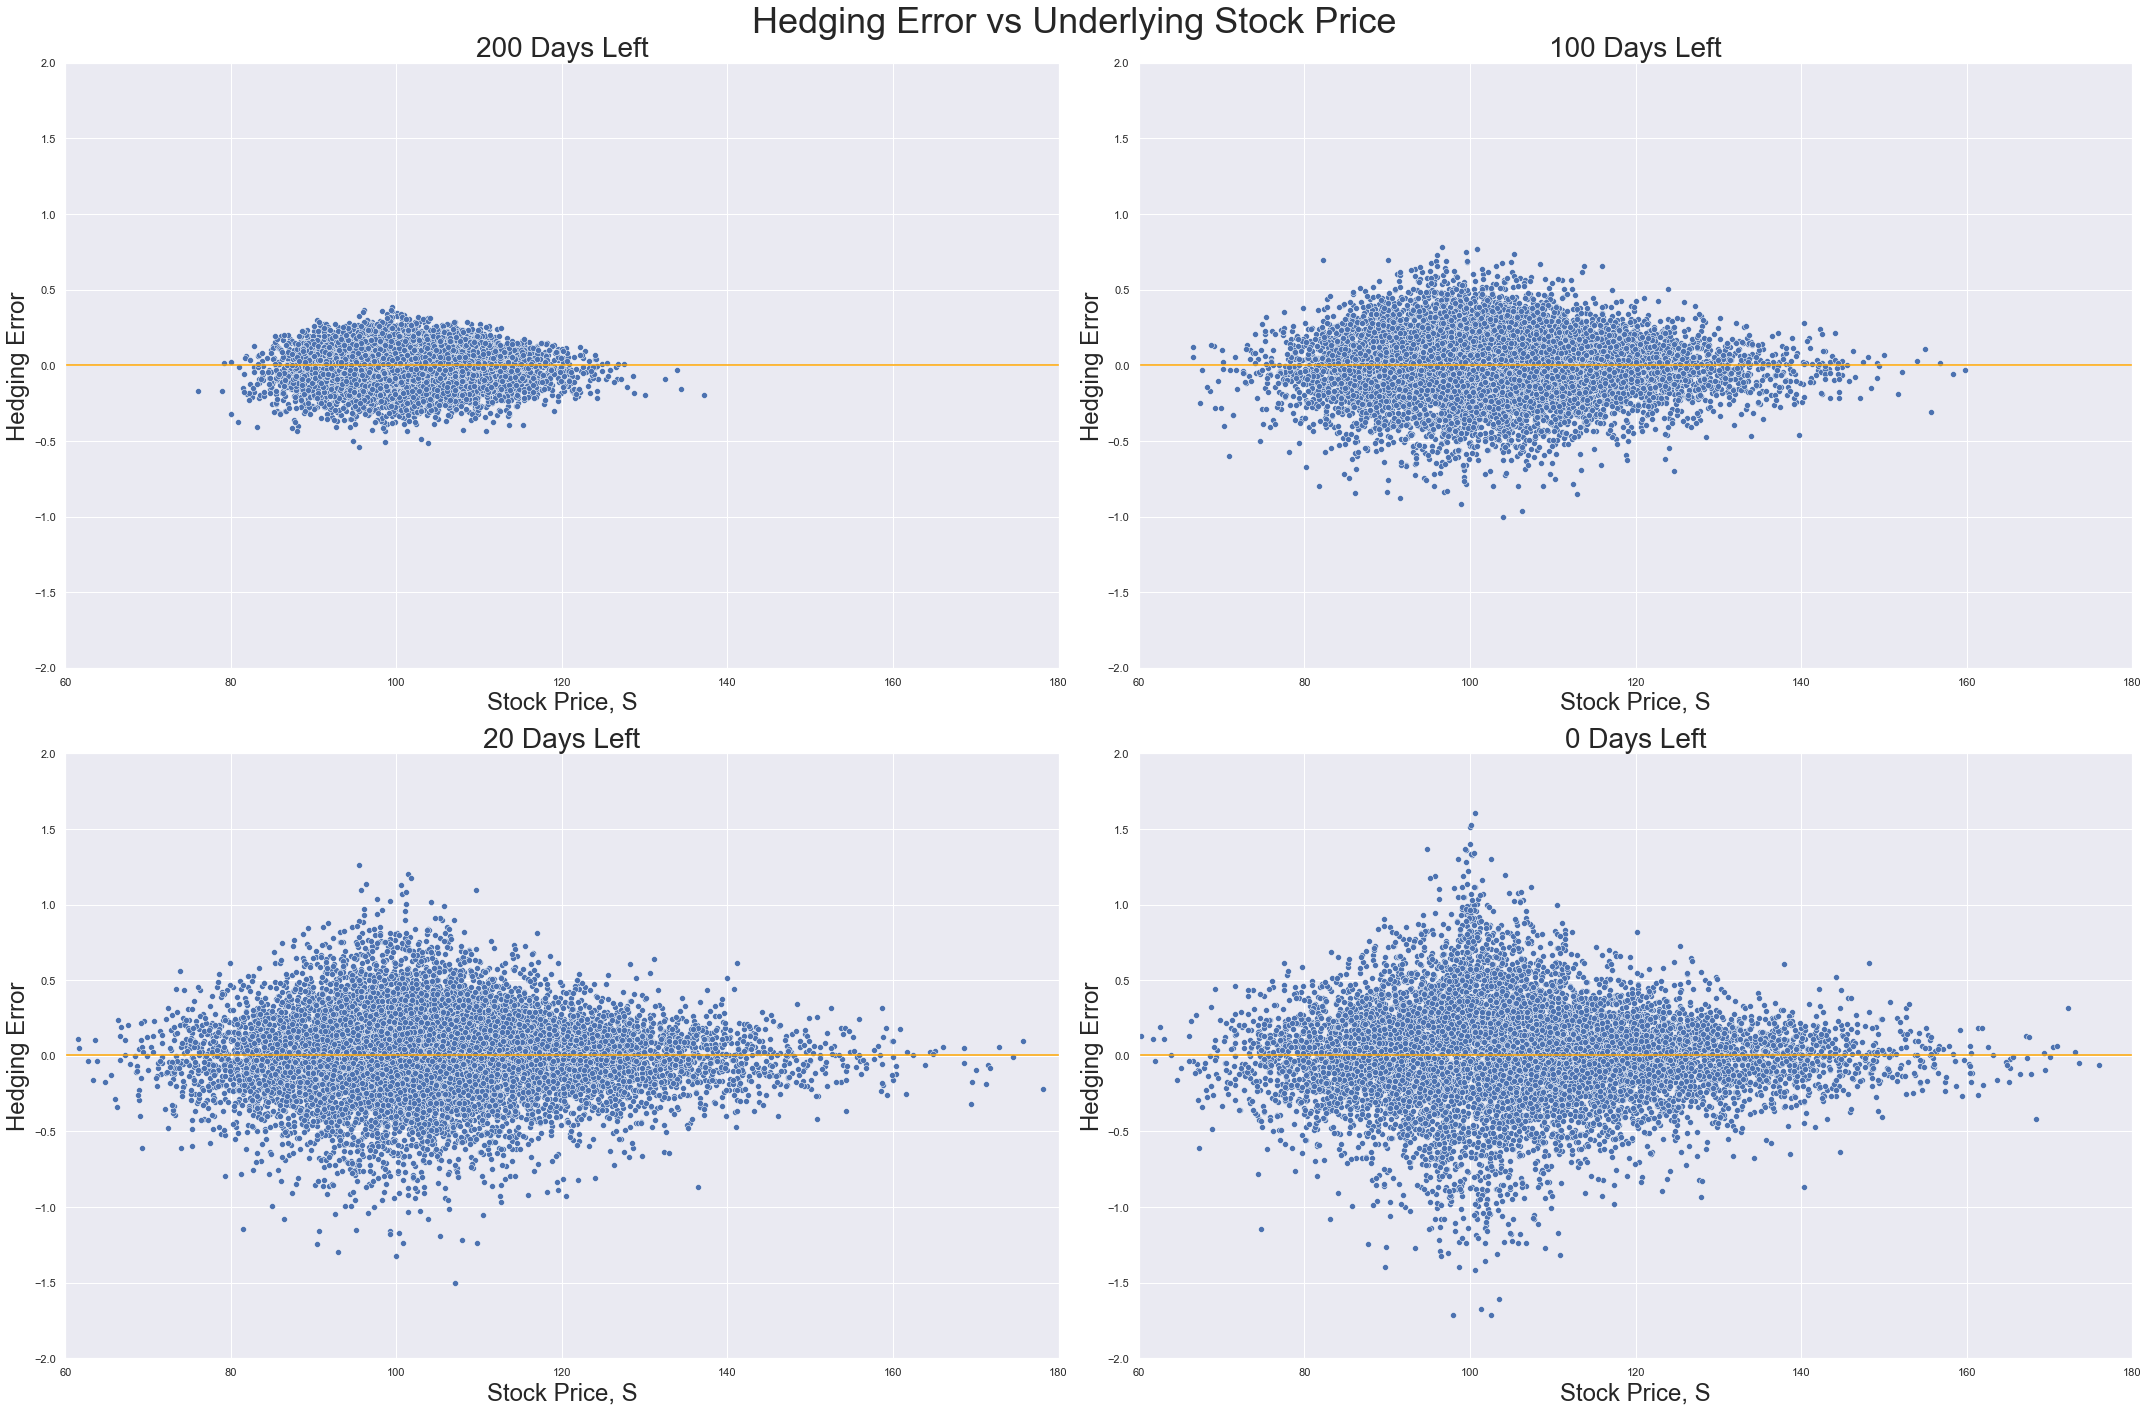

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))
axes = axes.reshape(-1)

ts = [-201, -101, -21, -1]

for t, ax in zip(ts, axes):
    
    prices = pxs[:, t]
    call_prices = call_pxs[:, t]
    repl_pxs = cbs[:, t] + stock_values[:, t]
    
    sns.scatterplot(prices, repl_pxs - call_prices, ax=ax)
    ax.axhline(np.mean(repl_pxs - call_prices), color='orange')

    ax.set_title("{} Days Left".format(-t-1), fontsize=28)
    ax.set_xlabel('Stock Price, S', fontsize=24)
    ax.set_ylabel('Hedging Error', fontsize=24)
    
    ax.set_xlim(60, 180)
    ax.set_ylim(-2, 2)

fig.suptitle('Hedging Error vs Underlying Stock Price', fontsize=36)
fig.tight_layout();

Quite a lot to take in here but let's go step by step. We have 4 graphs in the grid showing scatterplots of the combined value of our short call option and replicating portfolio position - each one showing the combined portfolio with `n` days left until expiry. I've standardised the axes so we can compare easily. What do we see?
 - there's an orange horizontal line stuck on for the mean hedging error and it confirms visual inspection that on average the delta replication is doing its job
 - as time passes the underlying stock price spreads out (it has more time to) and this leads to the graphs widening
 - as time toward expiry decreases we start to get wider variance of the overall pnl around the strike `K=100`

But overall it works. Or put differently, _on average_ it works. Without detracting too much, __it works because we've built it to work__ - we've set up a simulation under _perfect_ conditions for the Black-Scholes model and then through simulation shown it to be viable. In particular we have:
 - simulated stock prices using a known volatility, `sigma`, then used that same volatility to compute our deltas to hedge it on (what would happen if we don't know this or it changes?)
 - split time into daily increments for hedging - why did we choose this and what happens to the pnl distribution if we change this?

## Differing hedging frequencies

Let's now examine the assumption at the start that we will delta hedge daily - what happens if we were to hedge monthly? Or weekly? Or what about twice per day? Let's package up the code we have written above so we can deploy it nicely for various time splits.

In [35]:
# this will run our complete replciation with stock price simulation
def run_delta_hedge_sim(px, strike, risk_free, divs, sigma, years, points, sims):
    
    # churn out sims
    rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)
    # churn out option tvs, deltas and gammas
    call_pxs, deltas, gammas = compute_prices(pxs, K, risk_free, divs, sigma, points, years, call=True)
    # create replication values
    stock_values, cbs, cfs = generate_replications(pxs, deltas, call_pxs, risk_free, divs, points)
    
    return pxs, rets, call_pxs, stock_values + cbs, deltas, gammas


# package up code to create simulated replication portfolio
def generate_replications(pxs, deltas, call_pxs, risk_free, divs, points):
    
    # compute stock values at each point in time
    stock_values = pxs * deltas
    
    # compute cash flows from various activities
    # at each point we will add on cash flows to the future valued version
    # of last period's cash balance - this gives us our new cash balance

    # cash flow from delta hedging
    # compute cash generated from delta re-hedging
    delta_chgs = np.diff(deltas, axis=1)
    delta_rehedge_cfs = -delta_chgs * pxs[:,1:]

    # compute dividend income
    div_cfs = deltas[:,:-1] * pxs[:,:-1] * divs / points

    # compute starting premium and delta cfs
    start_cbs = call_pxs[:,0] - deltas[:,0] * pxs[:,0]

    # init our cash balance and cashflow arrays
    cbs = [start_cbs]
    cfs = [np.zeros(sims)]

    for drh, dcf in zip(delta_rehedge_cfs.T, div_cfs.T):

        # get previous cash balance
        prev_cash = cbs[-1]
        # future value it
        new_cash = prev_cash * (1 + risk_free / points)
        # add on new cash flows
        cf = drh + dcf
        cb = new_cash + cf
        cfs.append(cf)
        cbs.append(cb)

    cfs = np.array(cfs).T
    cbs = np.array(cbs).T

    return stock_values, cbs, cfs

Now let's check how our replication performs when we hedge at various time horizons. To do this we will still simulate a stock price over the course of a year, however we will simulate with varying time splits e.g. for daily as per before we will split into `252` increments, for twice daily split into `504` increments and monthly just `12`. Just as before then at each time split we will compute our delta, re-hedge as necessary and carry on.

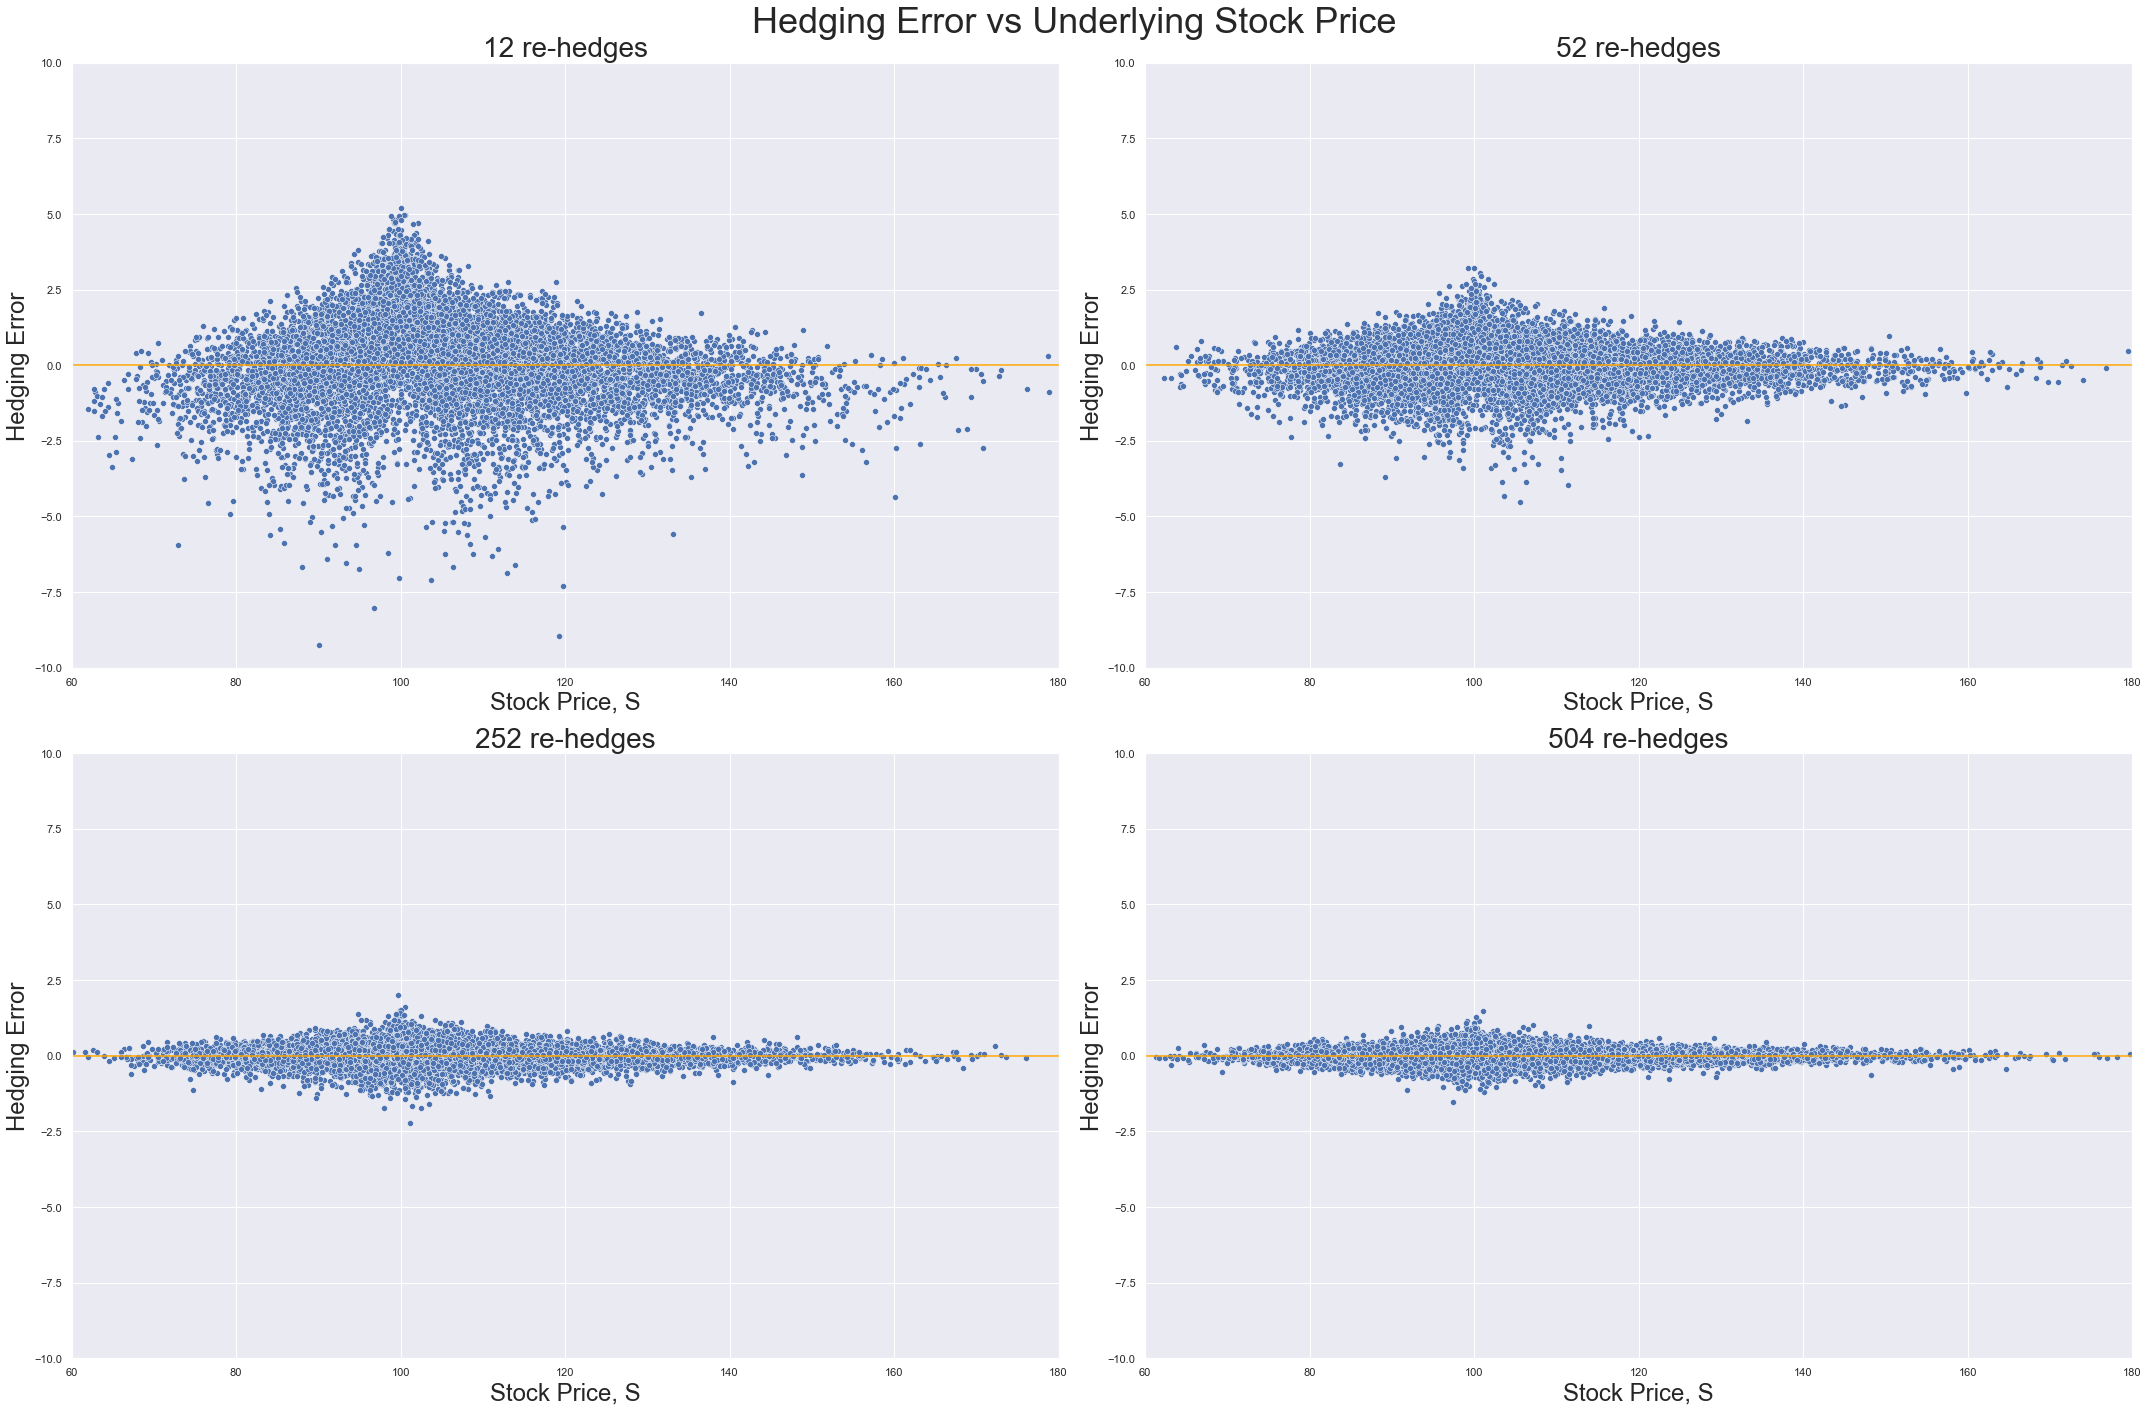

In [36]:
px = 100
K = 100
rf = 0.05
divs = 0.00
sigma = 0.16

years = 1
pts = [12, 52, 252, 504]
sims = 10000
perfs = {}

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))
axes = axes.reshape(-1)

for t, ax in zip(pts, axes):
    
    pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, K, rf, divs, sigma, years, t, sims)
    
    prices = pxs[:, -1]
    call_prices = call_pxs[:, -1]
    repl_pxs = repls[:, -1]
    
    perfs[t] = repl_pxs - call_prices
    
    sns.scatterplot(prices, repl_pxs - call_prices, ax=ax)
    ax.axhline(np.mean(repl_pxs - call_prices), color='orange')

    ax.set_title("{} re-hedges".format(t), fontsize=28)
    ax.set_xlabel('Stock Price, S', fontsize=24)
    ax.set_ylabel('Hedging Error', fontsize=24)
    
    ax.set_xlim(60, 180)
    ax.set_ylim(-10, 10)

fig.suptitle('Hedging Error vs Underlying Stock Price', fontsize=36)
fig.tight_layout();

So it seems clear (again, because I've standardised the axes) that the more frequent our hedging the lower our hedging error vs the theoretical option value. This kind of makes intuitive sense as long as we are using Gaussian returns (much more likely to get small returns than very large ones). This just states that if we chunk our time into smaller and smaller pieces then we are more likely to average in at the actual volatility - __because in this case volatility is only defined by when we choose to hedge.__

This last bit might need explaining. In theory we could have a stock process with annual log returns with a standard deviation of `16%` (as all above simulations have). However in practise if we hedge `12x` times i.e. monthly, we may end up with the lucky case where every time we come to hedge the underlying stock price just so happens to be back at `S=100`. In this example, even though we have daily fluctuations, if we were to calculate the standard deviation of returns based on the `12` times we hedged it would be `0` - because we stay at `S=100` and so every return is the same (`0%`).

This is an extreme example but it holds for the rest - the more frequent our hedging the more likely we are to average into a distribution of stock log returns which reflects the underlying volatility (which we are still assuming we know in advance). If we sell the option based on this volatility (which we do because that's how we created our starting call option price) then this will lead to lower hedging error in our replicating portfolio.

## Is there a relationship between hedging frequency and standard deviation of pnl?

In other words is there a tighter mathematical relationship we can draw between the two rather than just the vague "hedging more frequently reduces pnl volatility'. It turns out in the world we have constructed above (Gaussian returns etc) there is. The proof is a bit too mathsy for here but there's a cracking explanation of it in the start of Bergomi's famous book [Stochastic Volatility Modelling](https://www.lorenzobergomi.com/). It turns out that our hedging error should decrease with the square root of the frequency of our hedges i.e. hedging 4x as often should knock our hedging error in half.

Let's try it out - we'll do the same as the above but for a few more hedging time horizons and plot the associated standard deviation of the hedging error.

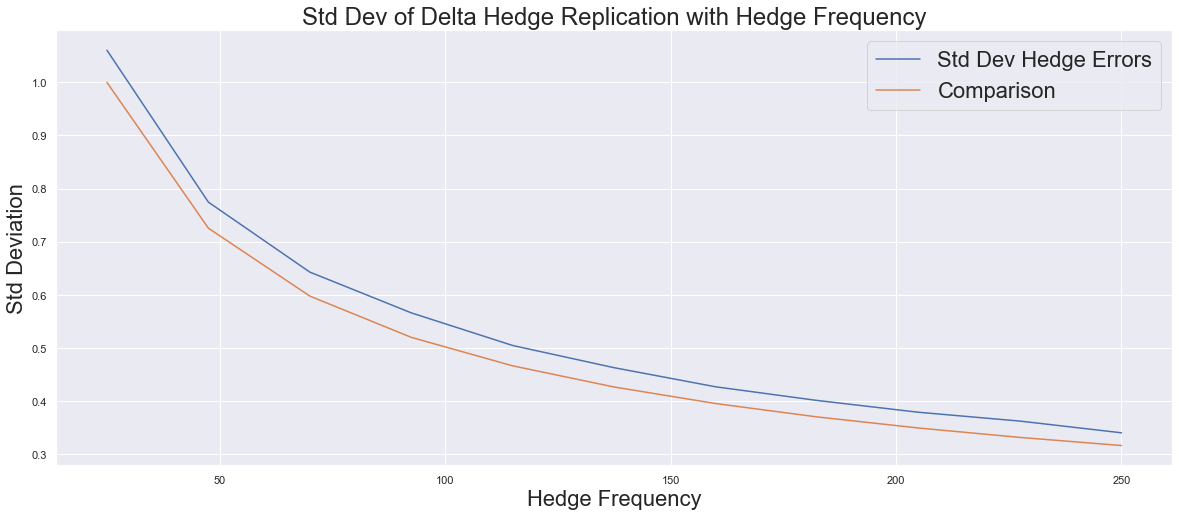

In [29]:
pts = np.linspace(25, 250, 11)
sims = 10000
hedge_errors = []

for t in pts:
    # generate replications
    pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, K, rf, divs, sigma, years, int(t), sims)
    # compute hedge error
    hedge_error = [repls[:, -1] - call_pxs[:, -1]]
    # append to hedge errors list
    hedge_errors.append(hedge_error)


# plot
fig, ax = plt.subplots(figsize=(20,8))

# plot hedge errors by hedge frequency
ax.plot(pts, [np.std(e) for e in hedge_errors], label='Std Dev Hedge Errors')
# plot 5 / sqrt(N) for comparison
ax.plot(pts, [(5 / (x**0.5)) for x in  pts], label='Comparison')

# label
ax.set_title('Std Dev of Delta Hedge Replication with Hedge Frequency', fontsize=24)
ax.set_xlabel('Hedge Frequency', fontsize=22)
ax.set_ylabel('Std Deviation', fontsize=22)
ax.legend(fontsize=22);

So it seems to check out - increasing your hedge frequency will decrease your hedging errors, but you will head into greater and greater diminishing returns.

## Why do we make money on some paths and lose on others?

This is something we just glossed over in the above. We accepted quite blindly that on average delta hedging worked (in our idealised world) because our average hedging error was basically zero. We didn't question why it is that on some paths we end up making money and on some paths we end up losing money. Now let's have a look a this - is there some way we can understand _why_ some paths produced positive hedging error whereas other paths cost us?

## Back to volatility

In the previous article we established the following: that buying options and delta hedging them can be viewed as 'buying volatility' (more accurately _variance_) because we will make more money from rebalancing our delta hedge over and over if the stock price moves around more. This is because we will likely have larger gaps in the prices which we buy (low) at and sell (high) at. We are also likely to have larger changes in our delta so we will be capitalising on this price differential in bigger quantities of stocks.

So can we use this logic to partition out our paths? Is it the case that on the paths where the _realised volatility_ was higher i.e. the actual realised stock log returns on that path were higher than our input `16%`, we lost money and vice versa? (We would lose money if volatility is higher here because in our example we are assuming that we _sold_ the call option). To do this let's define how we compute realised volatility then see if we can use this number to group our paths.

## Realised Volatility

To compute the realised volatility we do the following with the log returns:
 - square and then sum them
 - annualise them
 - take the square root

Mathematically this looks like the following for the realised volatility, `rv`:

$$ rv = \sqrt{\frac{252 * \sum_{i=1}^N r_t^2}{N}} $$

With that in mind we can now compute the realised volatility per path, bin our `10,000` simulations into groups and use those groups as a hue overlaying our graph of replication hedging errors. To note - the reason we have variance in our volatility is that each path could be viewed as a 'sample' and so the sample standard deviation will have a distribution around the 'population' parameter we input.

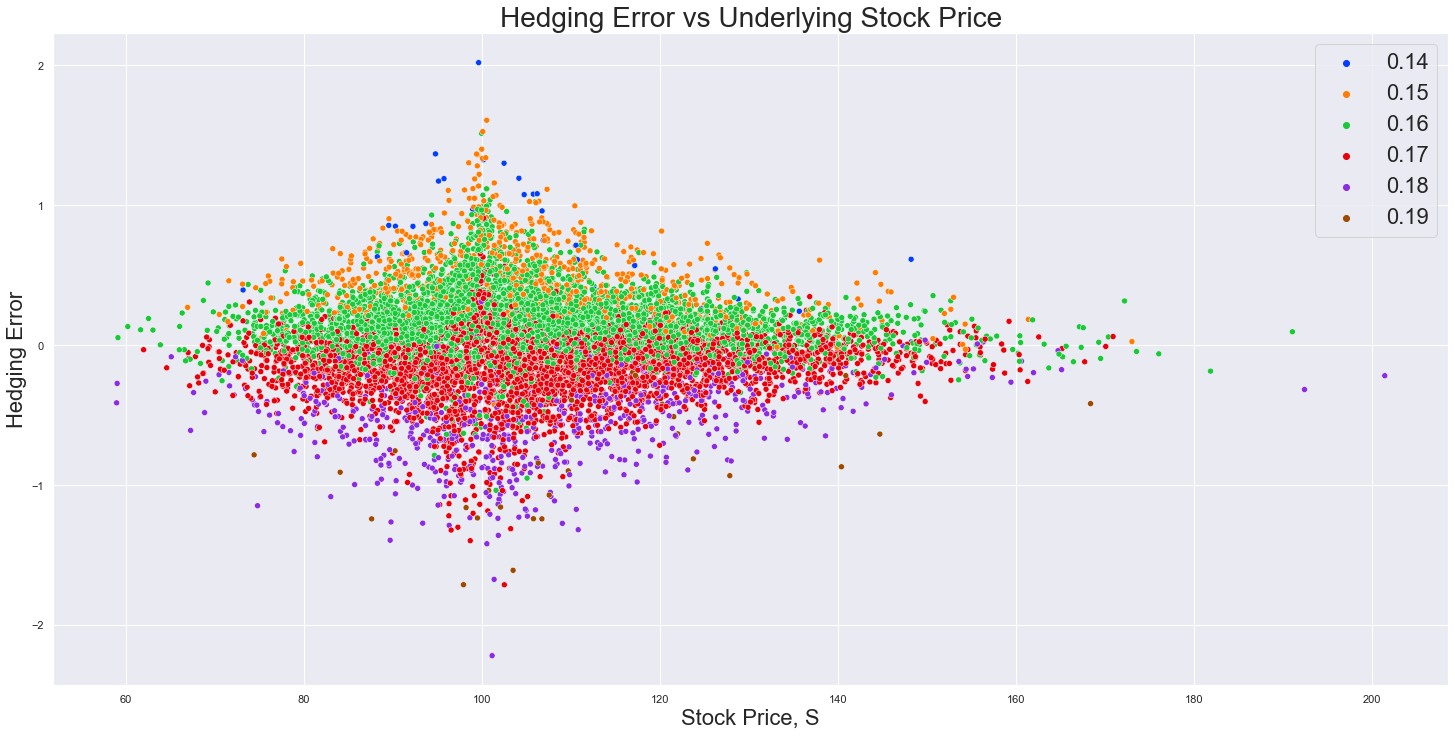

In [37]:
years = 1
points = 252
sims = 10000

pxs, rets, call_pxs, repls, deltas, gammas = run_delta_hedge_sim(px, K, rf, divs, sigma, years, points, sims)
rvs = np.insert(np.sqrt(np.divide(np.cumsum(rets**2, axis=1) * 252, np.arange(1, points+1))), 0, np.nan, axis=1)

bins = np.linspace(0.08, 0.30, 23)
bins = np.append(bins, 1)
bins = np.array([round(x, 2) for x in bins])

bin_inds = np.digitize(rvs[:, 1:], bins, right=True)
bin_rvs = bins[bin_inds]

fig, ax = plt.subplots(figsize=(25, 12))

sns.scatterplot(pxs[:, -1], (repls - call_pxs)[:, -1], hue=bin_rvs[:, -1], ax=ax, palette='bright')

ax.set_title('Hedging Error vs Underlying Stock Price', fontsize=28)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Hedging Error', fontsize=22)
ax.legend(fontsize=22);

Pretty. Now we can see quite clearly that the paths that experienced higher volatility than our delta was hedged on (`16%`) were more likely to cause negative replication errors, and those with lower volatility positive ones. In reality it is not _exactly_ the realised volatility we are exposed to but more the 'gamma weighted' realised volatility. In simple terms, we don't care if there is a very volatile move if our delta doesn't change because that means we don't need to buy/sell any stock on the back of it.

When we sell options this constant re-hedging behaviour costs us (called 'short gamma') but if we have very little gamma then the size of the move doesn't matter to us - big or small. So really we should be looking at some kind of weighting scheme on the returns where we apply larger weights to the moves we experience with a lot of gamma compared to the moves we experience with only a little gamma; rather than the standard deviation calculation which is just a straight average (every squared move gets the same weight).

## Conclusions

So we've now gone one step deeper to understand exactly how delta hedging works by using simulations to add some colour to the logic previously discussed. We still haven't touched on many topics - most notably if the above distribution of hedging errors is acceptable. It might be all well and good that we _average_ zero hedging errors, but unless we execute thousands and thousands of trades we may not achieve this average.

How big is the standard deviation of hedging errors versus what is normally charged by trading desks to manage these positions? This is obviously variable but to take a simple example we might charge '0.5 vol' to risk manage the above i.e. to sell the above call option and delta hedge it to achieve a replication.

In the case of the above `T=1`, `K=100` option this would amount to us charging `0.2` because the 'vega' (sensitivity to implied vol) is around `0.4`. As the above chart shows this is almost nothing in comparison to the realised hedging errors we would expect if all we did was delta hedge the position - back to the expression at the end of the last article: 'options hedge options'.

Next let's have a look at what happens if we use the 'wrong' volatility to compute our delta hedges on. In other words, if we simulate stock log returns with a known volatility but compute our delta with a volatility that _differs_ from this - how does our pnl distribution look?